<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Binary_classification_(logistic_regression_)_to_predict_cancer_status.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on Google Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")
def time_fmt(t:float)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f"---->testing: {time_fmt(123.87621)}")


Mounted at /content/drive
You are on Google Colab with tensorflow version: 2.4.1
---->testing: 0: 02: 03.00


In [ ]:
#In this notebook we will train a binary classification model on medical data
#to classify if an individual has a cancer or not. The simple mlp will be trained 
#and evaluation using the ROC curve and confussion matrix will be provided:

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
pd.set_option('max_rows', 6)
pd.set_option('max_columns', 0)

In [ ]:
dfm = pd.read_csv("https://data.heatonresearch.com/data/t81-558/wcbreast_wdbc.csv", na_values = ['NA','?'])

In [ ]:
dfm.isna().value_counts()

id     diagnosis  mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  mean_fractal_dimension  se_radius  se_texture  se_perimeter  se_area  se_smoothness  se_compactness  se_concavity  se_concave_points  se_symmetry  se_fractal_dimension  worst_radius  worst_texture  worst_perimeter  worst_area  worst_smoothness  worst_compactness  worst_concavity  worst_concave_points  worst_symmetry  worst_fractal_dimension
False  False      False        False         False           False      False            False             False           False                False          False                   False      False       False         False    False          False           False         False              False        False                 False         False          False            False       False             False              False            False                 False           False               

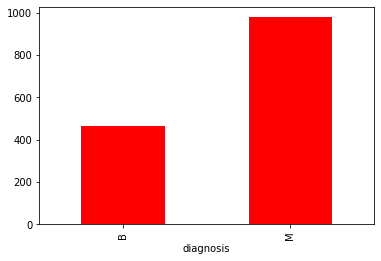

In [ ]:
#Ploting some patients characteristics wrt to cancer status:
dfm.groupby('diagnosis').mean_area.mean().plot(kind = 'bar', color = 'red')

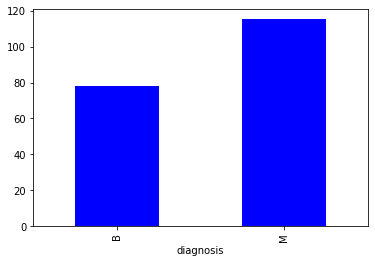

In [ ]:
dfm.groupby('diagnosis').mean_perimeter.mean().plot(kind = 'bar', color = 'blue')

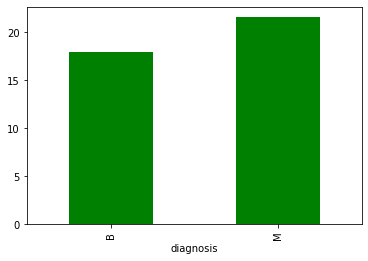

In [ ]:
dfm.groupby('diagnosis').mean_texture.mean().plot(kind = 'bar', color = 'green')

In [ ]:
#From above few plots we see that patients are likely to have cancer if the image has large mean-perimeter, mean-area, and mean-texture
#The classes are easy separable based on the given covariates (assuming the rest of the covariates displays the same)

In [ ]:
display(dfm)

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,se_radius,se_texture,se_perimeter,se_area,se_smoothness,se_compactness,se_concavity,se_concave_points,se_symmetry,se_fractal_dimension,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [ ]:
#We can label the targed as 1-for malignant and 0 for benign: No need to change into dummy:
#We can use apply function to get the job done

In [ ]:
target = dfm['diagnosis']
target = target.map({'M': 1, 'B': 0})

In [ ]:
display(target)

0      1
1      1
2      1
      ..
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [ ]:
#Check out for any class imbalance :
dfm.diagnosis.value_counts(normalize = True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [ ]:
#We can see that the data is not well balanced ...its skewed a litle towards malignants: during cross validation 
#we need to pay attention on the situation.

In [ ]:
x = dfm.drop(['id','diagnosis'], axis = 1)

In [ ]:
display(x)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,se_radius,se_texture,se_perimeter,se_area,se_smoothness,se_compactness,se_concavity,se_concave_points,se_symmetry,se_fractal_dimension,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.4280,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [ ]:
#We may rescale the covariates by obtaining their standard scores:
from scipy.stats import zscore

In [ ]:
columns = x.columns

In [ ]:
for col in columns:
  x[col] = zscore(x[col])

In [ ]:
display(x)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,se_radius,se_texture,se_perimeter,se_area,se_smoothness,se_compactness,se_concavity,se_concave_points,se_symmetry,se_fractal_dimension,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,0.184892,-0.257371,0.276693,0.180698,-0.379342,0.661277,0.510827,0.612157,-0.891416,0.036727,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
567,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,1.157935,0.686088,1.438530,1.009503,-0.173000,2.017716,1.302285,0.785721,0.326634,0.904057,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635
568,-1.808401,1.221792,-1.814389,-1.347789,-3.112085,-1.150752,-1.114873,-1.261820,-0.820070,-0.561032,-0.070279,0.383092,-0.157449,-0.466152,0.049342,-1.163516,-1.057501,-1.913447,0.752830,-0.382754,-1.410893,0.764190,-1.432735,-1.075813,-1.859019,-1.207552,-1.305831,-1.745063,-0.048138,-0.751207


In [ ]:
#Convert to numpy arrays

In [ ]:
target = target.values
x = x.values

In [ ]:
print(f"x_shape: {x.shape}, target_shape: {target.shape}")

x_shape: (569, 30), target_shape: (569,)


In [ ]:
#split the data into training and validation set and convert into tensorflow datatype for easy streaming in:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train,y_test = train_test_split(x, target, test_size = 0.2)

In [ ]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (455, 30), y_train_shape: (455,)
x_test_shape: (114, 30), y_test_shape: (114,)


In [ ]:
BUFFER = 1024
BATCH_SIZE = 16
EPOCHS = 10
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(BUFFER).batch(batch_size = BATCH_SIZE, drop_remainder = True)
evaluation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
evaluation_data = evaluation_data.shuffle(BUFFER).batch(batch_size = BATCH_SIZE, drop_remainder = True)
x_sample_train_batch, y_sample_train_batch = next(iter(train_data))

In [ ]:
print(f"train_batch_sample_x_shape: {x_sample_train_batch.shape}, train_batch_sample_y_shape:{y_sample_train_batch.shape}")

train_batch_sample_x_shape: (16, 30), train_batch_sample_y_shape:(16,)


In [ ]:
#Buiding the model:

Model: "mlp_logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               3968      
_________________________________________________________________
dense2 (Dense)               (None, 64)                8256      
_________________________________________________________________
outputs (Dense)              (None, 1)                 65        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


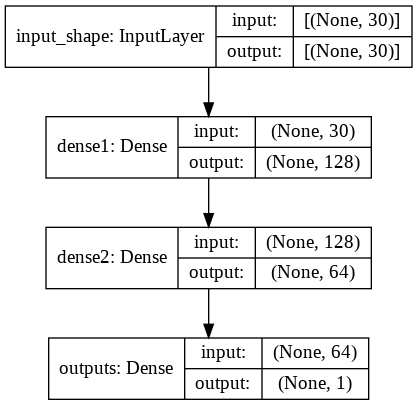

In [ ]:
inputs = tf.keras.Input(shape = (30,), name = 'input_shape')
x = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense1')(inputs)
x = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense2')(x)
outputs = tf.keras.layers.Dense(units = 1, activation = 'linear', name = 'outputs')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_logistic')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'mlp_logistc.png', show_shapes = True)

In [ ]:
#Training the model from scratch: we first obtain the loss function, metrics and optimizers:

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()
metric_train = tf.keras.metrics.BinaryAccuracy()
metric_eval = tf.keras.metrics.BinaryAccuracy()
optimizer = tf.keras.optimizers.RMSprop()

In [ ]:
#The training loop:
#Training loop from the scratch:
tic = time.time()
for epoch in range(EPOCHS):
  print(f"The start of epoch: {epoch}")
  for (step, (x_train_batch, y_train_batch)) in enumerate(train_data):
    with tf.GradientTape() as tape:
      y_preds = model(x_train_batch, training = True)
      loss = loss_object(y_train_batch, y_preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    metric_train.update_state(y_train_batch, y_preds)
    train_acc = metric_train.result()
    metric_train.reset_states()
    if step % 200 == 0:
      print(f"epoch: {epoch}, training accuracy: {float(train_acc):.4f}")
      print(f"batch {step + 1} train loss: {float(loss): .4f}")
    
  for (step, (x_val_batch, y_val_batch)) in enumerate(evaluation_data):
    y_preds = model(x_val_batch, training = False)
    loss = loss_object(y_val_batch, y_preds)
    metric_eval.update_state(y_val_batch, y_preds)
    val_acc = metric_eval.result()
    metric_eval.reset_states()

    if step % 200 == 0:
      print(f"epoch: {epoch}, validation accuracy: {float(val_acc):.4f}")
      print(f"batch: {step + 1}: validation loss: {float(loss):.4f}")

toc = time.time()
print(f"time elapse is : {time_fmt(toc - tic)}")

The start of epoch: 0
epoch: 0, training accuracy: 0.6250
batch 1 train loss:  0.6705
epoch: 0, validation accuracy: 1.0000
batch: 1: validation loss: 0.0135
The start of epoch: 1
epoch: 1, training accuracy: 0.9375
batch 1 train loss:  0.0713
epoch: 1, validation accuracy: 1.0000
batch: 1: validation loss: 0.0000
The start of epoch: 2
epoch: 2, training accuracy: 1.0000
batch 1 train loss:  0.0579
epoch: 2, validation accuracy: 1.0000
batch: 1: validation loss: 0.0000
The start of epoch: 3
epoch: 3, training accuracy: 0.9375
batch 1 train loss:  0.0568
epoch: 3, validation accuracy: 1.0000
batch: 1: validation loss: 0.0000
The start of epoch: 4
epoch: 4, training accuracy: 0.9375
batch 1 train loss:  0.1032
epoch: 4, validation accuracy: 1.0000
batch: 1: validation loss: 0.0009
The start of epoch: 5
epoch: 5, training accuracy: 1.0000
batch 1 train loss:  0.0000
epoch: 5, validation accuracy: 1.0000
batch: 1: validation loss: 0.0000
The start of epoch: 6
epoch: 6, training accuracy: 1

In [ ]:
#Assessing the accuracy of the model by vissualizing the roc-curve and confusion matrix:

In [ ]:
preds = model.predict(x_test)
print(preds[0:10])

[[-1.1479479]
 [-1.9214013]
 [ 5.678086 ]
 [ 1.5319724]
 [-1.3889518]
 [-1.6436973]
 [-0.8370602]
 [-1.2226479]
 [ 6.8699236]
 [-2.39678  ]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#Ploting the roc_curve

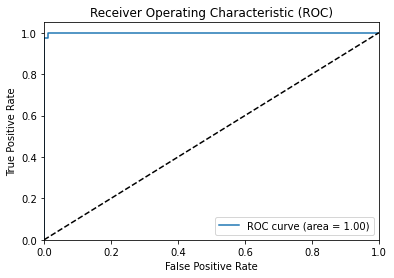

In [ ]:
plot_roc(preds, y_test)

In [ ]:
#From the roc curve above we see that the accuracy of the model is almost 100%